<h2 align="center">Similar Product Recommendation</h2>

In [1]:
#Importing pre-trined models for transfer learning
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import cv2
#Importing unsupervised learning models
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import cosine_similarity
#Dimensionality reduction technique
from sklearn.decomposition import PCA

In [2]:
#Product image directory
productDirectory = r"xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

In [3]:
#Configuring vgg16 with Imagenet weights for transfer learning.
#Removing last layer of the model for custom process.
#Setting the model retrainable to false to use the existing weights.
model_base = VGG16(weights='imagenet', include_top=False)
flatten_layer = layers.Flatten()
model = models.Sequential([model_base,flatten_layer,])
model.trainable = False

In [4]:
# Function to 
#    1. preprocess and augment the image.
#    2. extract the image features using vgg16
def GetImageFeatures(fileName):
    imagePath = os.path.join(productDirectory,fileName)
    imageGenerated = image.load_img(imagePath, target_size=(80, 60))
    imgArray = image.img_to_array(imageGenerated)
    imgExpDim = np.expand_dims(imgArray, axis=0)
    processedImageInput = preprocess_input(imgExpDim)
    imageFeatures = model.predict(processedImageInput)
    return imageFeatures

# Function to display source and recommended products.
def DisplayImage(imagePath,title):
    fig = plt.figure(figsize=(3*len(imagePath), 3))
    columns = len(imagePath)
    rows = 1
    for i in range(0, columns*rows):
        img = cv2.imread(imagePath[i])[:,:,::-1]
        fig.add_subplot(rows, columns, i+1)
        plt.title(title+f" {i+1}")
        plt.imshow(img)
    plt.show()

In [5]:
# Extracting features for the product images present in the DB.
productfiles = [f for f in os.listdir(productDirectory) if os.path.isfile(os.path.join(productDirectory, f))]
feature_dataset = list(map(GetImageFeatures,productfiles))
# Squeezing the features to 1D.
imageFeaturesSq = np.squeeze(feature_dataset)
featureDataset = np.array(imageFeaturesSq)

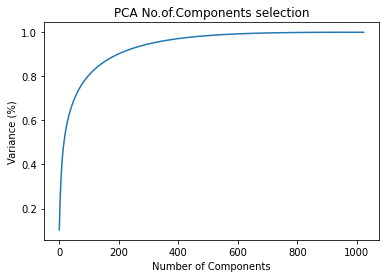

In [6]:
# fitting the extracted features in PCA to get to know the number of significant components to choose.
pca = PCA().fit(featureDataset)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA No.of.Components selection')
plt.show()

In [7]:
#Applying Dimensionality reduction technique.
pca = PCA(n_components=300)
pca.fit(np.array(featureDataset))
featuresPCA = pca.transform(featureDataset)

### Method 1: Neighbors Tree

In [8]:
#Proving the PCA components to KDTree to process similar Item.
similarItemTree = KDTree(featuresPCA)

Please provide an input image name for SimilarItem Recommendation: 105429371.jpg


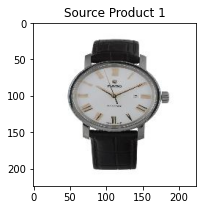

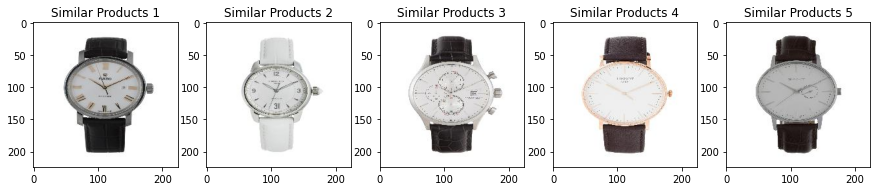

In [10]:
# Geting the source item for generating the recommendation.
sourceImage = input("Please provide an input image name for SimilarItem Recommendation: ")
sourceProductFeatures = GetImageFeatures(sourceImage)
sourceFeatureDataset = np.array(sourceProductFeatures)
sourcePcaComponents = pca.transform(sourceFeatureDataset)
_ , SimilarItemIndex = similarItemTree.query(sourcePcaComponents, k=5)

#Display Source product
sourceImage_path = os.path.join(productDirectory,sourceImage)
DisplayImage([sourceImage_path],"Source Product")

#Display Similar products
similarImg_paths = [os.path.join(productDirectory,productfiles[i]) for i in SimilarItemIndex[0]]
DisplayImage(similarImg_paths,"Similar Products")

### Method 2: Categorical Similarity Check

In [11]:
#Calculating cosing Similarity for all the products in the DB
productCosineSimilarity = cosine_similarity(featuresPCA)
productCosineSimilarities_df = pd.DataFrame(productCosineSimilarity, columns=productfiles, index=productfiles)

In [12]:
# Geting the source item for generating the recommendation.
sourceImage_2 = input("Please provide an input image name for Similar product Recommendation: ")
sourceProductFeatures_2 = GetImageFeatures(sourceImage_2)
sourceFeatureDataset_2 = np.array(sourceProductFeatures_2)
sourcePcaComponents_2 = pca.transform(sourceFeatureDataset_2)

Please provide an input image name for Similar product Recommendation: 105489047.jpg


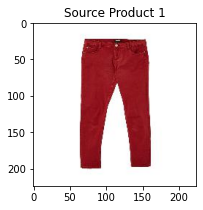

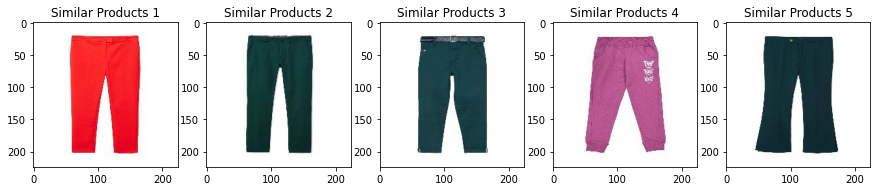

In [13]:
#Display Source product
sourceImage_path_2 = os.path.join(productDirectory,sourceImage_2)
DisplayImage([sourceImage_path_2],"Source Product")

#Display Similar products
SimilarProducts = productCosineSimilarities_df[sourceImage_2].sort_values(ascending=False)[1:5+1].index
similarImg_paths_2 = [os.path.join(productDirectory,i) for i in SimilarProducts]
DisplayImage(similarImg_paths_2,"Similar Products")

### Method 3: K Means Clustering

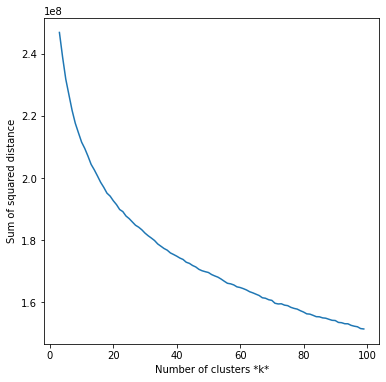

In [14]:
# Selecting the number of clusters to form.
# Considering min cluster for quick processing
sse = []
list_k = list(range(3, 100))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
    km.fit(featuresPCA)
    sse.append(km.inertia_)

# Ploting SSE against K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [15]:
# cluster feature vectors
kmeans = KMeans(n_clusters=100,n_jobs=-1, random_state=22)
kmeans.fit(featuresPCA)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [16]:
# groups hold the cluster id and the images.
groups = {}
for file, cluster in zip(productfiles,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [17]:
# Function to view the clusters formed.       
def view_cluster(cluster):
    plt.figure(figsize = (100,100));
    files = groups[cluster]
    files = files[:5]
    similarImg_paths_3 = [os.path.join(productDirectory,i) for i in files]
    DisplayImage(similarImg_paths_3,"Similar Products")

<Figure size 7200x7200 with 0 Axes>

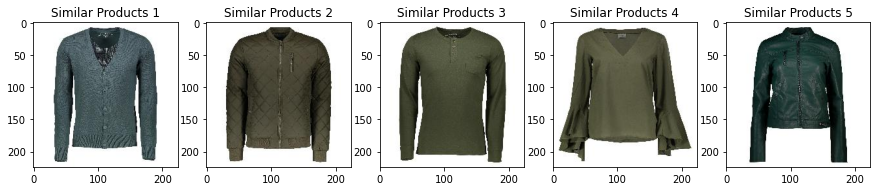

In [22]:
#Displaying cluster
view_cluster(6)